In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
with uproot.open("../pythia/output/dataset_ttbar_mu60_NumEvents10000_MinJetpT25.root:fastjet") as f:
    jet_pufr = f["jet_pufr_truth"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_m = f["jet_m"].array()

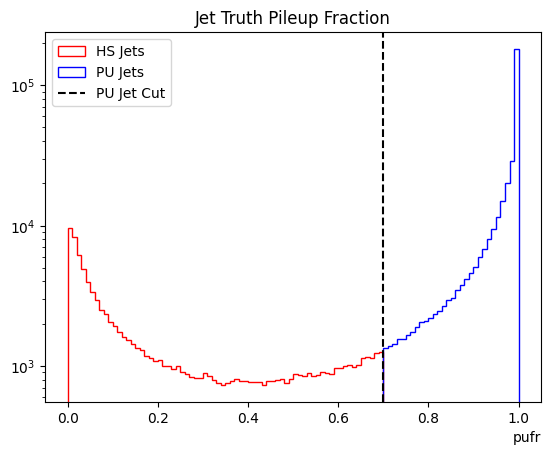

In [3]:
threshold = 0.7

sig = (jet_pufr < threshold)
bkg = ~sig

plt.title("Jet Truth Pileup Fraction")
plt.hist(ak.ravel(jet_pufr[sig]),histtype='step',bins=int(100*threshold),label='HS Jets',color='r')
plt.hist(ak.ravel(jet_pufr[bkg]),histtype='step',bins=int(100*(1-threshold)),label='PU Jets',color='b')
plt.axvline(x = threshold, color = 'k', label = 'PU Jet Cut',linestyle='dashed')
plt.xlabel("pufr",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

In [4]:
feat_list = [jet_pt,jet_eta,jet_phi,jet_m,jet_corrJVF,jet_RpT]
norm_list = []
for feat in feat_list:
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm_list.append((feat-mean)/std)
feat_list = [x[:,:,np.newaxis] for x in norm_list]
jet_feats = ak.concatenate(feat_list, axis=2)

threshold = 0.7
jet_labels = ak.values_astype((ak.Array(jet_pufr) < threshold), int)

num_events = len(jet_pt)
train_split = int(0.7*num_events)
test_split = int(0.75*num_events)

batch_size = 128
num_batches = int(train_split / batch_size)-1

X_train = jet_feats[0:train_split]
y_train = jet_labels[0:train_split][:,:,np.newaxis]

batches = []
labels = []
for i in range(num_batches):
    b = torch.nested.nested_tensor(ak.to_list(X_train[i*batch_size:(i+1)*batch_size]), dtype=torch.float32, layout=torch.jagged, requires_grad=True)
    l = torch.nested.nested_tensor(ak.to_list(y_train[i*batch_size:(i+1)*batch_size]), dtype=torch.float32, layout=torch.jagged)
    batches.append(b)
    labels.append(l)
    
X_train = batches
X_val = torch.nested.nested_tensor(ak.to_list(jet_feats[train_split:test_split]), dtype=torch.float32, layout=torch.jagged)
X_test = torch.nested.nested_tensor(ak.to_list(jet_feats[test_split:]), dtype=torch.float32, layout=torch.jagged)

y_train = labels
y_val = torch.nested.nested_tensor(ak.to_list(jet_labels[train_split:test_split]), dtype=torch.int32, layout=torch.jagged)
y_test = torch.nested.nested_tensor(ak.to_list(jet_labels[test_split:]), dtype=torch.int32, layout=torch.jagged)

In [5]:
class MultiHeadAttention(nn.Module):
    """
    Computes multi-head attention. Supports nested or padded tensors.

    Args:
        E_q (int): Size of embedding dim for query
        E_k (int): Size of embedding dim for key
        E_v (int): Size of embedding dim for value
        E_total (int): Total embedding dim of combined heads post input projection. Each head
            has dim E_total // nheads
        nheads (int): Number of heads
        dropout_p (float, optional): Dropout probability. Default: 0.0
    """
    def __init__(self, E_q: int, E_k: int, E_v: int, E_total: int,
                 nheads: int, dropout_p: float = 0.0):
        super().__init__()
        self.nheads = nheads
        self.dropout_p = dropout_p
        self.query_proj = nn.Linear(E_q, E_total)
        self.key_proj = nn.Linear(E_k, E_total)
        self.value_proj = nn.Linear(E_v, E_total)
        E_out = E_q
        self.out_proj = nn.Linear(E_total, E_out)
        assert E_total % nheads == 0, "Embedding dim is not divisible by nheads"
        self.E_head = E_total // nheads

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor) -> torch.Tensor:
        """
        Forward pass; runs the following process:
            1. Apply input projection
            2. Split heads and prepare for SDPA
            3. Run SDPA
            4. Apply output projection

        Args:
            query (torch.Tensor): query of shape (N, L_t, E_q)
            key (torch.Tensor): key of shape (N, L_s, E_k)
            value (torch.Tensor): value of shape (N, L_s, E_v)

        Returns:
            attn_output (torch.Tensor): output of shape (N, L_t, E_q)
        """
        # Step 1. Apply input projection
        # TODO: demonstrate packed projection
        query = self.query_proj(query)
        key = self.key_proj(key)
        value = self.value_proj(value)

        # Step 2. Split heads and prepare for SDPA
        # reshape query, key, value to separate by head
        # (N, L_t, E_total) -> (N, L_t, nheads, E_head) -> (N, nheads, L_t, E_head)
        query = query.unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        # (N, L_s, E_total) -> (N, L_s, nheads, E_head) -> (N, nheads, L_s, E_head)
        key = key.unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        # (N, L_s, E_total) -> (N, L_s, nheads, E_head) -> (N, nheads, L_s, E_head)
        value = value.unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)

        # Step 3. Run SDPA
        # (N, nheads, L_t, E_head)
        attn_output = F.scaled_dot_product_attention(
            query, key, value, dropout_p=self.dropout_p, is_causal=False)
        # (N, nheads, L_t, E_head) -> (N, L_t, nheads, E_head) -> (N, L_t, E_total)
        attn_output = attn_output.transpose(1, 2).flatten(-2)

        # Step 4. Apply output projection
        # (N, L_t, E_total) -> (N, L_t, E_out)
        attn_output = self.out_proj(attn_output)

        return attn_output

class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        #self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.Attention = MultiHeadAttention(32,32,32,32,1)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        #context, weights = self.attention(Query, Key, Value)
        context = self.Attention(Query, Key, Value)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent

class AttnModel(nn.Module):
    def __init__(self, in_feats, embed_dim, num_heads, out_classes):
        super(AttnModel, self).__init__()        
        self.preprocess = nn.Linear(in_feats,embed_dim)
        self.encoder1 = Encoder(embed_dim, num_heads)
        self.classifier = nn.Linear(embed_dim,out_classes)
    def forward(self, jet_feats):
        jet_embedding = F.gelu(self.preprocess(jet_feats))
        jet_embedding = self.encoder1(jet_embedding,jet_embedding,jet_embedding)
        output = F.sigmoid(self.classifier(jet_embedding))
        return output

In [6]:
def BCE_Loss(preds, targets):
    loss_fn = nn.BCELoss()
    loss = 0.0
    for pred, target in zip(preds.unbind(), targets.unbind()):
        #print(len(pred))
        loss += loss_fn(pred, target)
    print(loss)
    return loss

In [7]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'val_loss':[]}
   
    for e in range(epochs):     
        cum_loss_train = []
        cum_loss_val = []

        num_batches = len(X_train)
        model.train()
        for i in range(num_batches):
            optimizer.zero_grad()
            
            padded_X_train = torch.nested.to_padded_tensor(X_train[i], padding=-999)
            padded_y_train = torch.nested.to_padded_tensor(y_train[i], padding=-999)
            
            output = model(padded_X_train.to(device))
      
            loss = BCE_Loss(output, padded_y_train.to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        model.eval()
        y_pred = model(X_val.to(device))
        loss = BCE_Loss(y_pred,y_val.to(device))
        cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['val_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tVal Loss:',round(float(np.mean(cum_loss_val)),4))

    return history

In [8]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [9]:
model = AttnModel(6,32,1,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

data = [X_train, y_train, X_val, y_val]

#history = train(model, data)

print(model(X_train[0].to(device)))
print(y_train[0])

NestedTensor(size=(128, j1, 1), offsets=tensor([   0,   22,   71,   96,  126,  166,  205,  278,  312,  343,  383,  441,
         509,  568,  632,  680,  712,  741,  770,  808,  869,  883,  946,  998,
        1076, 1099, 1139, 1165, 1232, 1266, 1321, 1403, 1414, 1437, 1490, 1581,
        1632, 1651, 1697, 1752, 1795, 1834, 1905, 1942, 1988, 2025, 2066, 2165,
        2207, 2262, 2289, 2343, 2394, 2471, 2518, 2565, 2612, 2659, 2714, 2751,
        2767, 2808, 2843, 2865, 2918, 2953, 2987, 3015, 3045, 3092, 3125, 3185,
        3234, 3280, 3320, 3387, 3412, 3449, 3467, 3511, 3578, 3603, 3669, 3687,
        3737, 3814, 3866, 3889, 3943, 4009, 4035, 4074, 4156, 4230, 4240, 4275,
        4310, 4340, 4353, 4382, 4408, 4445, 4482, 4515, 4559, 4630, 4664, 4691,
        4754, 4764, 4780, 4817, 4849, 4882, 4902, 4936, 4994, 5043, 5085, 5126,
        5195, 5221, 5257, 5306, 5354, 5425, 5444, 5470, 5516], device='cuda:0'), grad_fn=<SigmoidBackward0 object at 0x774c955cf820>, contiguous=True)
NestedTen

In [25]:
import torch
import torch.nn.functional as F

# Example nested tensors with requires_grad=True
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
b = torch.tensor([4.0, 5.0, 6.0, 7.0], requires_grad=True)
nested_tensor = torch.nested.nested_tensor([a, b])

# Example target nested tensor
target_a = torch.tensor([1.0, 2.0, 3.0])
target_b = torch.tensor([4.0, 5.0, 6.0, 7.0])
target_nested_tensor = torch.nested.nested_tensor([target_a, target_b])

# Unbind the nested tensor
unbound_tensors = nested_tensor.unbind()
target_unbound_tensors = target_nested_tensor.unbind()

# Compute the loss for each tensor
def compute_loss(unbound_tensors, target_unbound_tensors):
    total_loss = 0.0
    for pred, target in zip(unbound_tensors, target_unbound_tensors):
        total_loss += F.mse_loss(pred, target)
    return total_loss

# Calculate the total loss
loss = compute_loss(unbound_tensors, target_unbound_tensors)
print("Total Loss:", loss.item())

# Backward pass
loss.backward()

# Check gradients
print("Gradients for a:", a.grad)
print("Gradients for b:", b.grad)

Total Loss: 0.0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [22]:
import torch

# Example nested tensors
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
b = torch.tensor([4.0, 5.0, 6.0, 7.0], requires_grad=True)
nested_tensor = torch.nested.nested_tensor([a, b], requires_grad=True)

# Convert to padded tensor
padded_tensor = torch.nested.to_padded_tensor(nested_tensor, padding=0.0)

# Example target tensor (also padded)
target = torch.tensor([[1.0, 2.0, 3.0, 0.0], [4.0, 5.0, 6.0, 7.0]])

# Create a mask
mask = (padded_tensor != 0.0).float()

# Compute loss with masking
loss = torch.nn.functional.mse_loss(padded_tensor * mask, target * mask)
print("Loss:", loss.item())

# Backward pass
loss.backward()

# Check gradients
print("Gradients for a:", a.grad)
print("Gradients for b:", b.grad)

Loss: 0.0
Gradients for a: None
Gradients for b: None


In [23]:
import torch
import torch.nn.functional as F

# Example nested tensors
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
b = torch.tensor([4.0, 5.0, 6.0, 7.0], requires_grad=True)
nested_tensor = torch.nested.nested_tensor([a, b], requires_grad=True)

# Convert to padded tensor
padded_tensor = torch.nested.to_padded_tensor(nested_tensor, padding=0.0)

# Define MHA layer
mha = torch.nn.MultiheadAttention(embed_dim=4, num_heads=2, batch_first=True)

# Example query, key, value tensors
query = padded_tensor.unsqueeze(0)  # Add batch dimension
key = padded_tensor.unsqueeze(0)
value = padded_tensor.unsqueeze(0)

# Pass through MHA layer
attn_output, _ = mha(query, key, value)

# Create a mask
mask = (padded_tensor != 0.0).float()

# Example target tensor (also padded)
target = torch.tensor([[1.0, 2.0, 3.0, 0.0], [4.0, 5.0, 6.0, 7.0]])

# Compute loss with masking
loss = F.mse_loss(attn_output.squeeze(0) * mask, target * mask)
print("Loss:", loss.item())

# Backward pass
loss.backward()

# Check gradients
print("Gradients for a:", a.grad)
print("Gradients for b:", b.grad)


Loss: 22.53557014465332
Gradients for a: None
Gradients for b: None
